In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

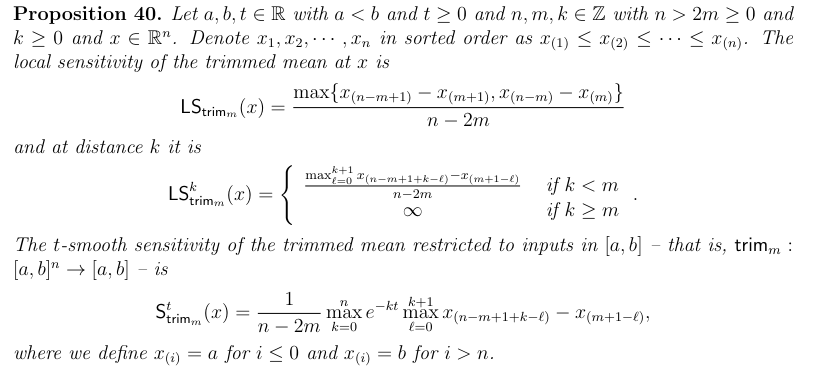

In [22]:
# Equivalent to xs[idx]
# but if idx is out of bounds, returns the lower bound (a) or upper bound (b)
def bounded_get(xs, idx, a, b):
    if idx < 0:
        return a
    elif idx >= len(xs):
        return b
    else:
        return xs[idx]

# Compute S_trim^t, the t-smooth sensitivity of the trimmed mean
# xs: the array we are taking the mean of
# t: the smoothing parameter (a number greater than 0, e.g. 0.1 or 1.0)
# a: the lower bound for the data (e.g. 0)
# b: the upper bound for the data (e.g. 10)
# the data in xs will be clipped to lie between a and b
def compute_sens(xs, t, m, a, b):
    # n is the length of xs
    n = len(xs)
    
    # clip the array and sort it
    clipped_xs = xs.clip(a, b)
    sorted_xs = np.sort(xs)

    # the outer max in the figure above
    # this fills in the list with the values to take the max over
    # the max is taken at the end of the function
    scaled_sensitivity_at_distances = []
    for k in range(0, n+1):
        scaling = np.exp(- k * t) # inner scaling factor exp(-kt)
        
        # compute the numbers to maximize for the inner max in the figure above
        # each value is a difference between two values from xs
        # but some of the indices lie outside xs
        # this is why we use bounded_get, which returns
        # the upper or lower bound if we go off the end of the array
        inner_max_target = [bounded_get(xs, n-m+1+k-l, a, b) -\
                            bounded_get(xs, m+1-l, a, b) for l in range(0, k+2)]
        inner_max = np.max(inner_max_target)

        # apply the inner scaling factor exp(-kt)
        scaled_inner = np.exp(- k * t) * inner_max
        
        # append this inner result to the set considered in the outer max
        scaled_sensitivity_at_distances.append(scaled_inner)

    # compute the outer max
    outer_max = np.max(np.array(scaled_sensitivity_at_distances))
    
    # scale the outer max by 1/(n-2m) as above
    return (1/(n - 2*m)) * outer_max

In [30]:
# a test array of size 256 (random numbers)
test_array = np.random.normal(loc=5, scale=1, size=256)

In [31]:
# compute the sensitivity
# t = 1
# m = 5 (trim 5 elements off each end of the array)
# lower bound a = 0
# upper bound b = 10
compute_sens(test_array, 1, 5, 0, 10)

0.00034074489848560225

In [36]:
%%time

# It takes a long time to run. This computes sensitivity 200 times, and takes about 3 seconds on my machine.

t = 1
m = 5
lower = 0
upper = 10
reps = 200

sensitivities = [compute_sens(test_array, t, m, lower, upper) for _ in range(reps)]

CPU times: user 3.43 s, sys: 32 µs, total: 3.43 s
Wall time: 3.42 s


# Notes

- The test above takes 3 seconds on my machine, for an array of size 256
- We need to run this on minibatches of size at least 128-256 or maybe higher (so - at least as large as the test array)
- We need to run it once per element of the gradient - so, once per model weight
- We have to do this whole thing once per iteration of training
- So, the above suggests that for a model with 200 weights, we will spend 3 seconds computing sensitivities per iteration
- It needs to be in the milliseconds range for this to be plausible for large models

# Ideas

- `xs` changes every time we compute sensitivity
- The indices we query *don't* change
- We could precompute the indices we need to check for each `k`
- We could vectorize the querying of the indices and re-use the precomputed indices each time
- How can we vectorize the outer max? Do we need a matrix of `k` copies of `xs`?